# The master raw CSD plot

In [1]:
import src.paths

In [2]:
def resample_1250_250_Hz(df):
    idx = df.index[::5]
    t1 = pd.date_range(start=0, periods=len(df), freq='0.8ms')
    t2 = pd.date_range(start=0, periods=len(df) // 5, freq='4ms')
    df = df.set_index(t1).reindex(t2).interpolate(method='linear')
    return df.set_index(idx)

In [3]:
DATE = '2022-09-16'
CHANNEL_MIN = 0
CHANNEL_MAX = 59
THETA_LOW = 2
THETA_HIGH = 15

In [4]:
%%time
csd = pd.read_pickle(src.paths.DATA / DATE / f'{DATE}-hpc-csd.pkl')
csd = csd.loc[0:7200 - 1 / 1250, CHANNEL_MIN:CHANNEL_MAX] * 0.001

CPU times: user 655 ms, sys: 3.5 s, total: 4.15 s
Wall time: 15.4 s


In [5]:
%%time
csd.to_parquet(src.paths.DATA / DATE / f'{DATE}-hpc-csd-channel-{CHANNEL_MIN}-{CHANNEL_MAX}.parquet')

CPU times: user 12.7 s, sys: 4.63 s, total: 17.3 s
Wall time: 26.8 s


In [6]:
%%time
sos = scipy.signal.butter(5, Wn=[2, 15], fs=1250, btype='band', output='sos')
theta = scipy.signal.sosfiltfilt(sos, csd.values, axis=0)
theta = pd.DataFrame(theta, index=csd.index, columns=csd.columns)

CPU times: user 12 s, sys: 2.26 s, total: 14.3 s
Wall time: 14.3 s


In [7]:
%%time
csd = resample_1250_250_Hz(csd)
theta = resample_1250_250_Hz(theta)

CPU times: user 5.74 s, sys: 2.57 s, total: 8.3 s
Wall time: 8.3 s


In [8]:
%%time
hilbert = scipy.signal.hilbert(theta.values)
hilbert = pd.DataFrame(hilbert, index=csd.index, columns=csd.columns)

CPU times: user 2.11 s, sys: 964 ms, total: 3.07 s
Wall time: 3.07 s


In [9]:
%%time
spikes = pd.read_pickle(src.paths.DATA / DATE / f'{DATE}-hpc-spikes.pkl')
spikes = spikes.loc[0:7200 - 1 / 250, CHANNEL_MIN * 4:CHANNEL_MAX * 4 + 3]

CPU times: user 0 ns, sys: 719 ms, total: 719 ms
Wall time: 7.64 s


In [10]:
%%time
coact = (spikes > 0).T.groupby(spikes.columns.to_frame().channel // 4).sum().T
coact = pd.DataFrame(coact, index=spikes.index, columns=csd.columns)

CPU times: user 1.98 s, sys: 1.66 s, total: 3.63 s
Wall time: 3.63 s


---

In [11]:
minute = 10

In [12]:
offset = np.arange(60 * minute, 60 * (minute + 1), 10)

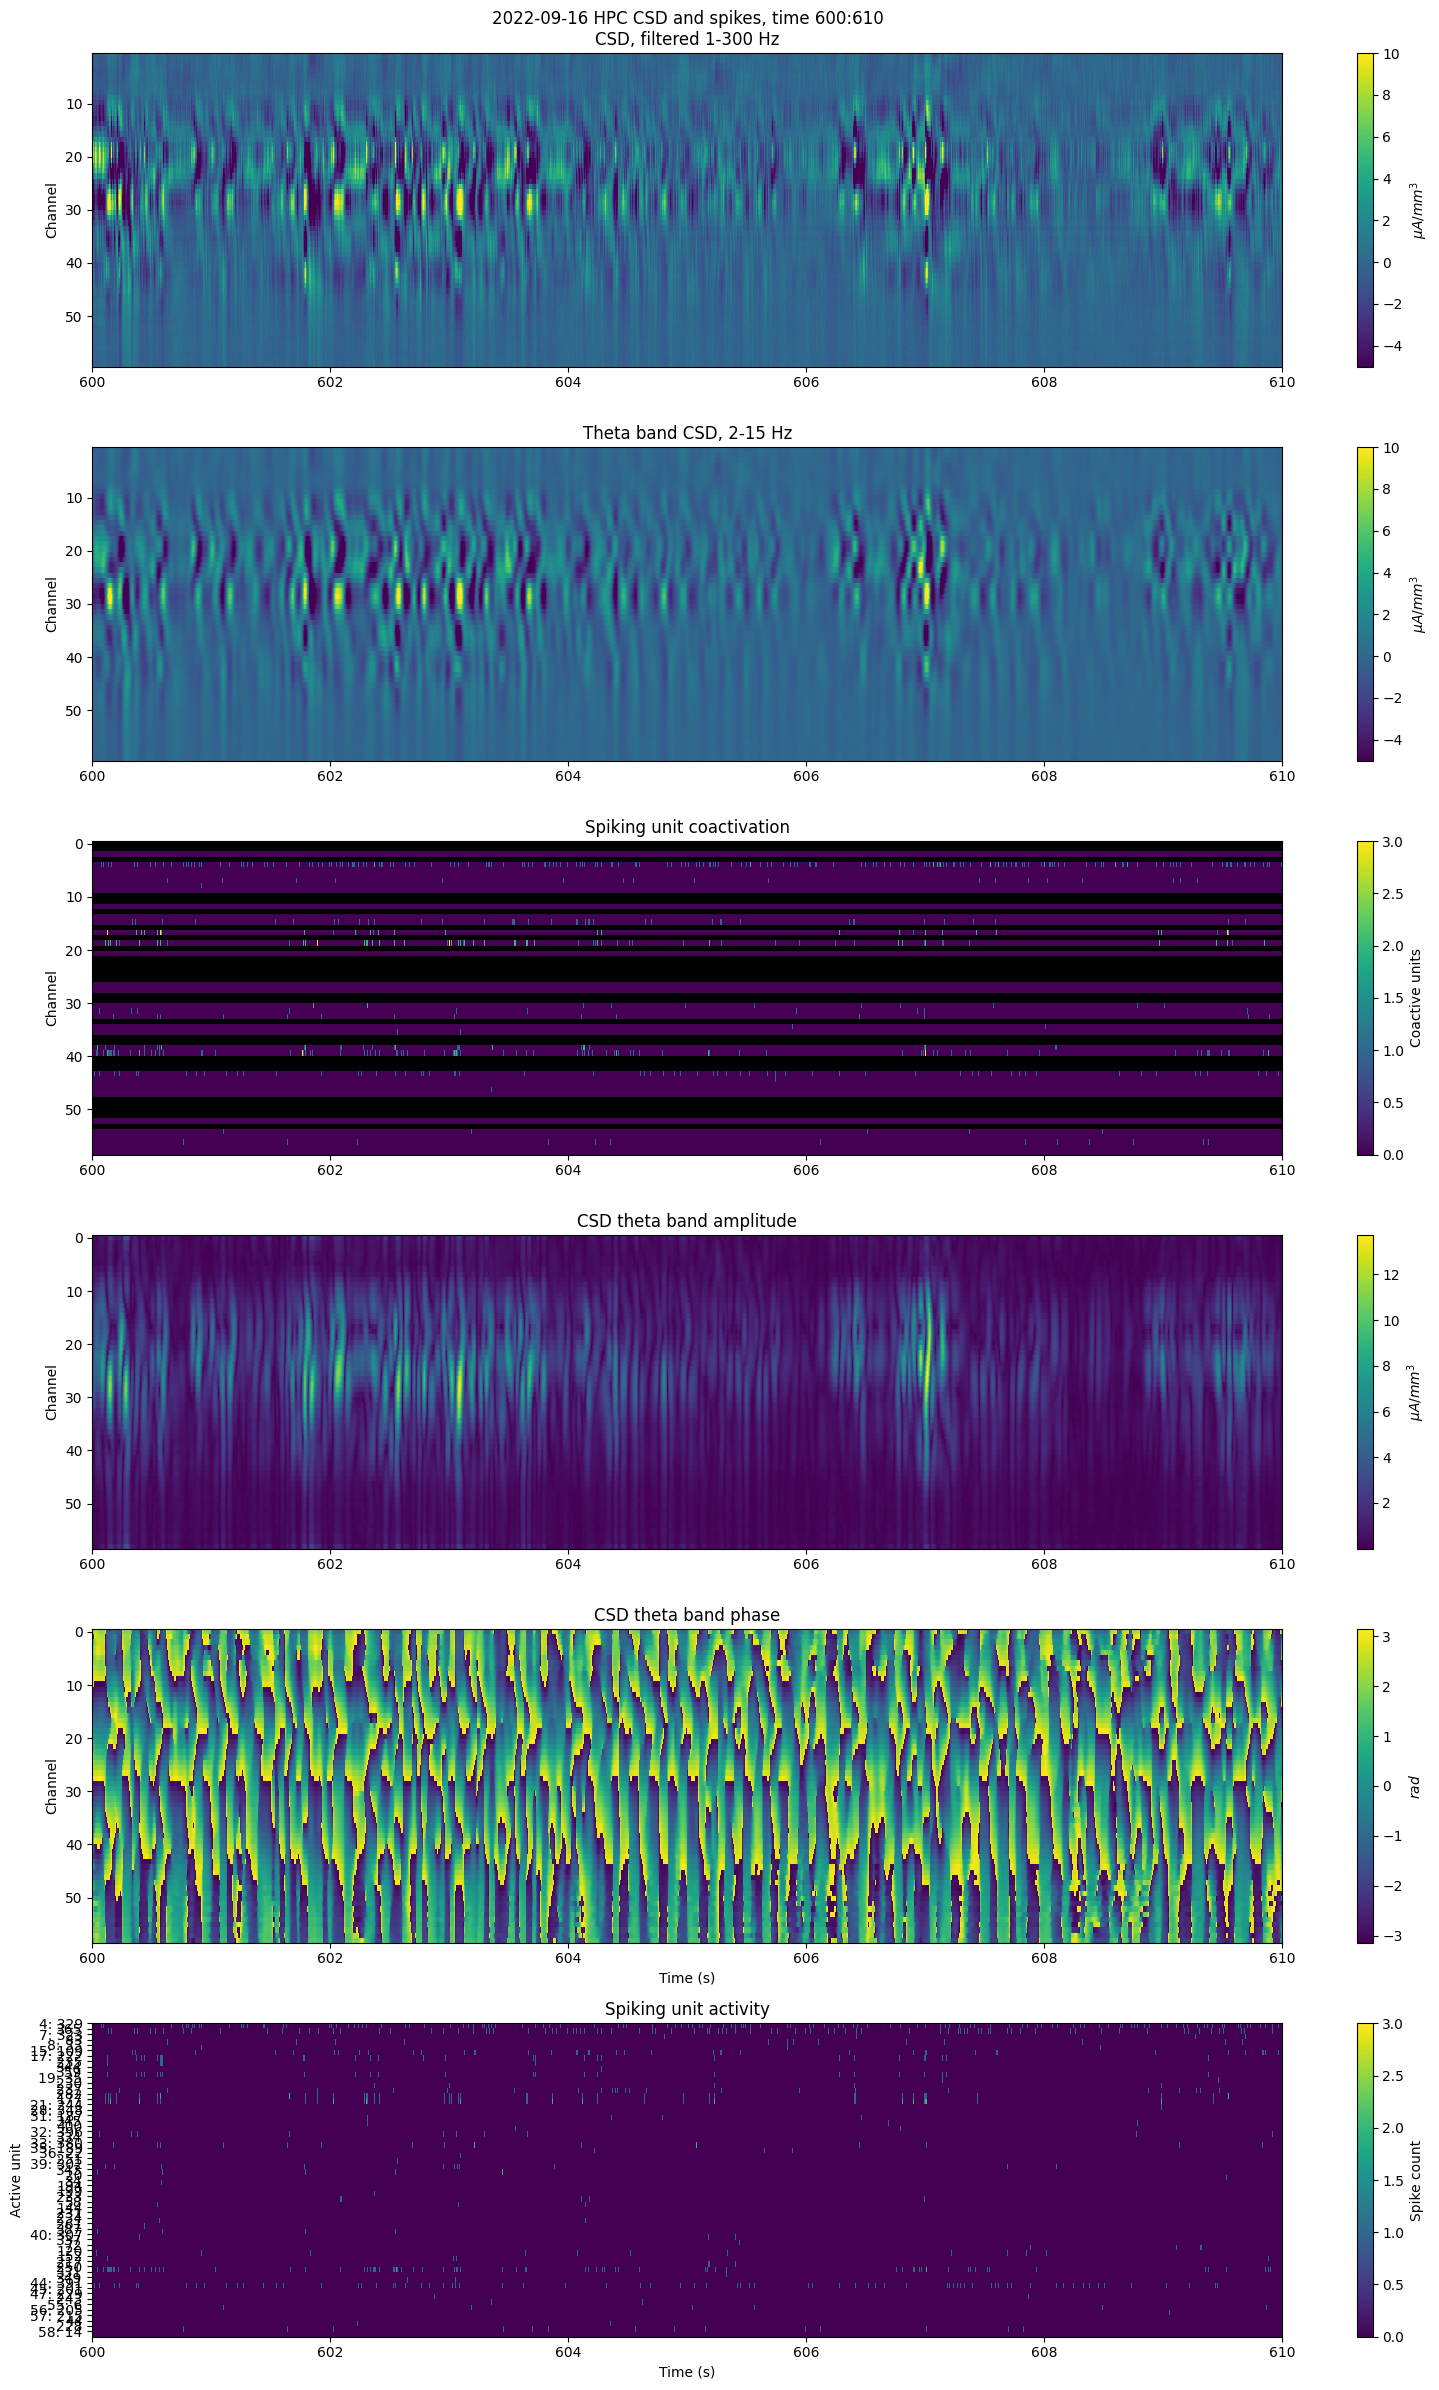

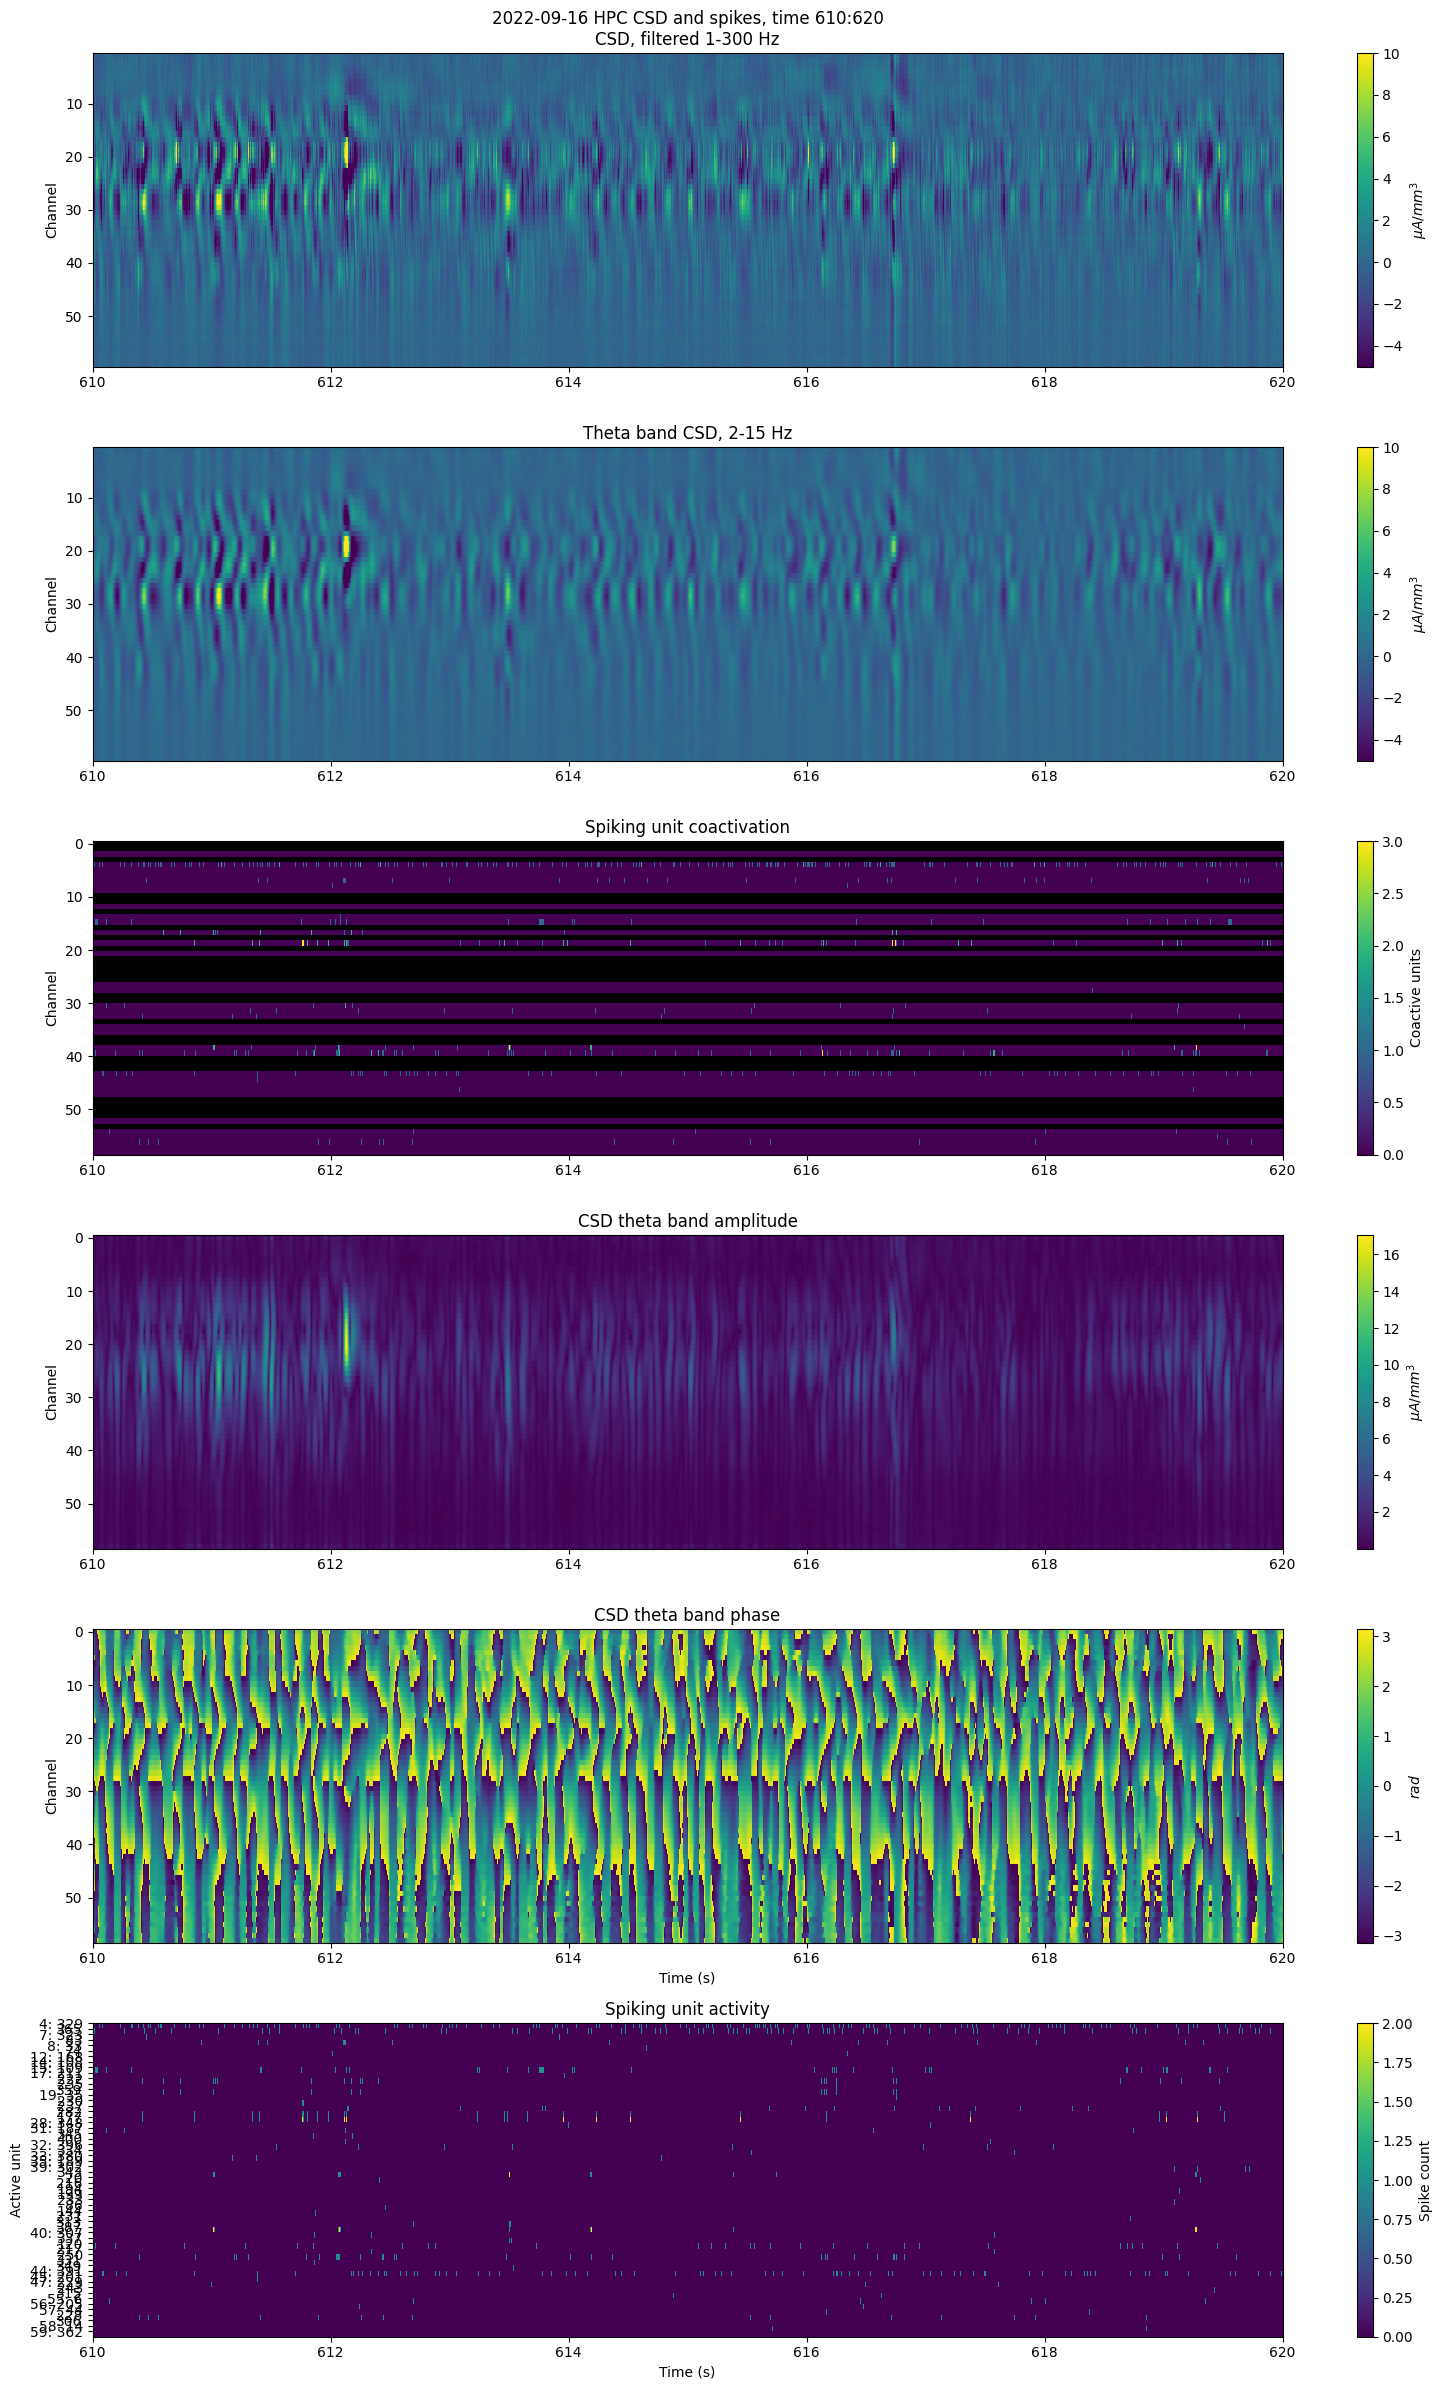

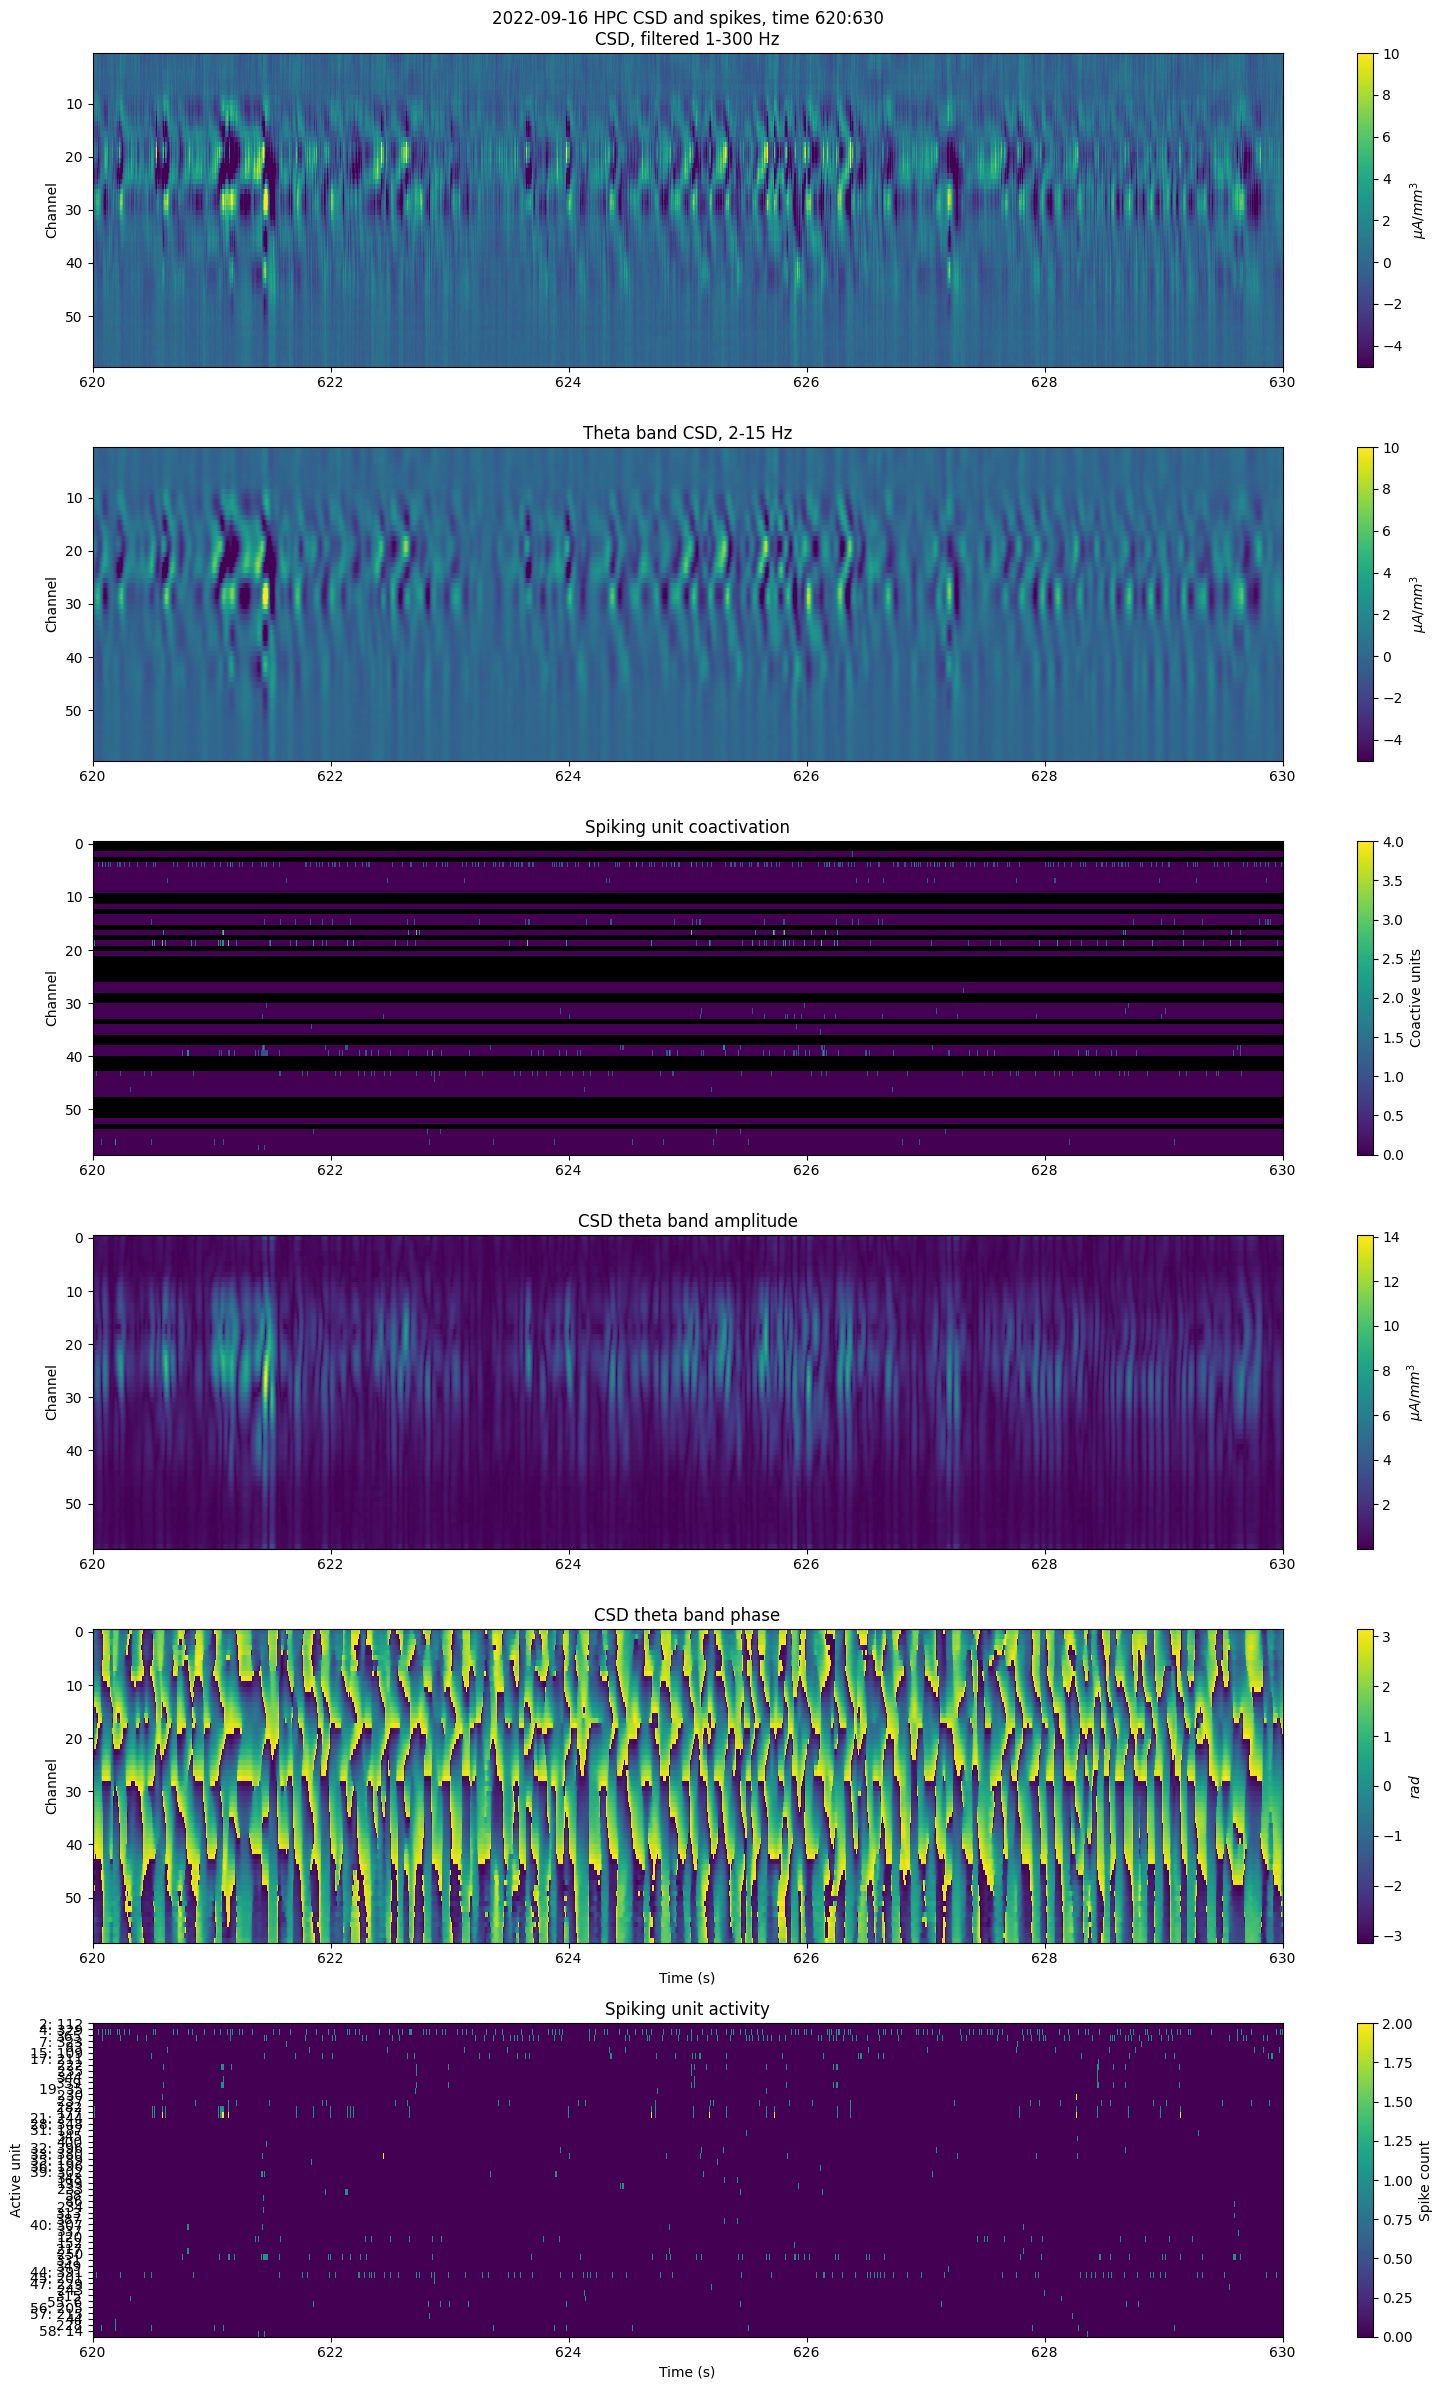

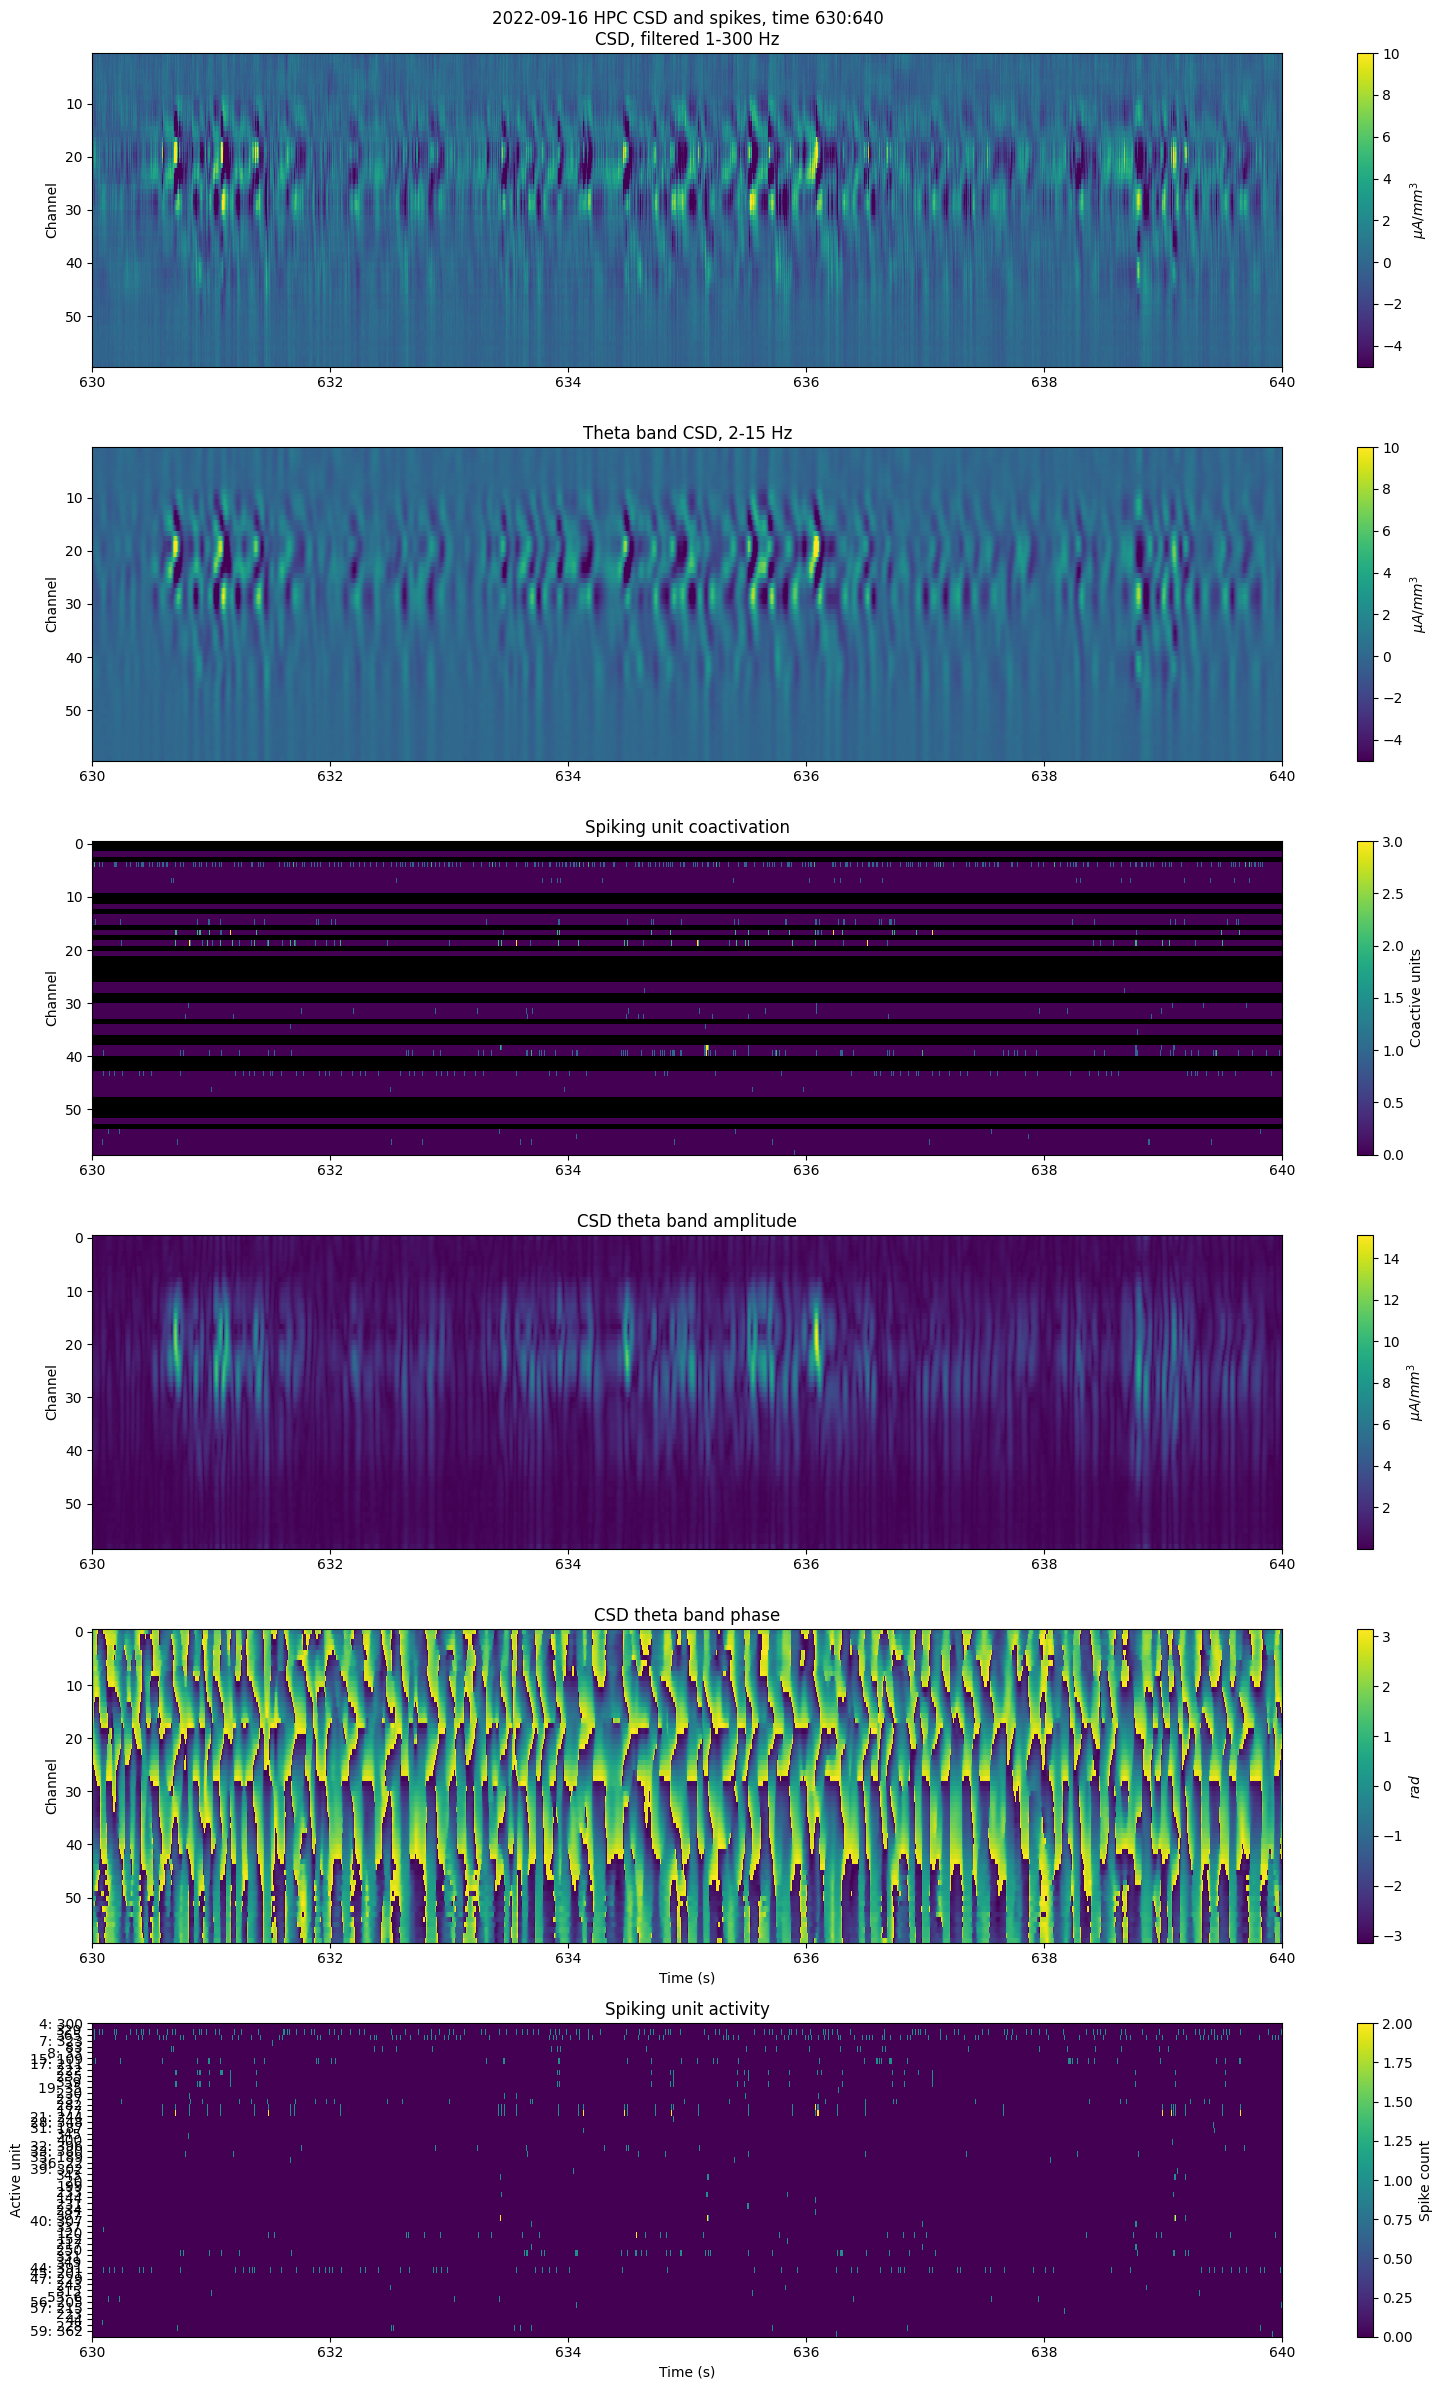

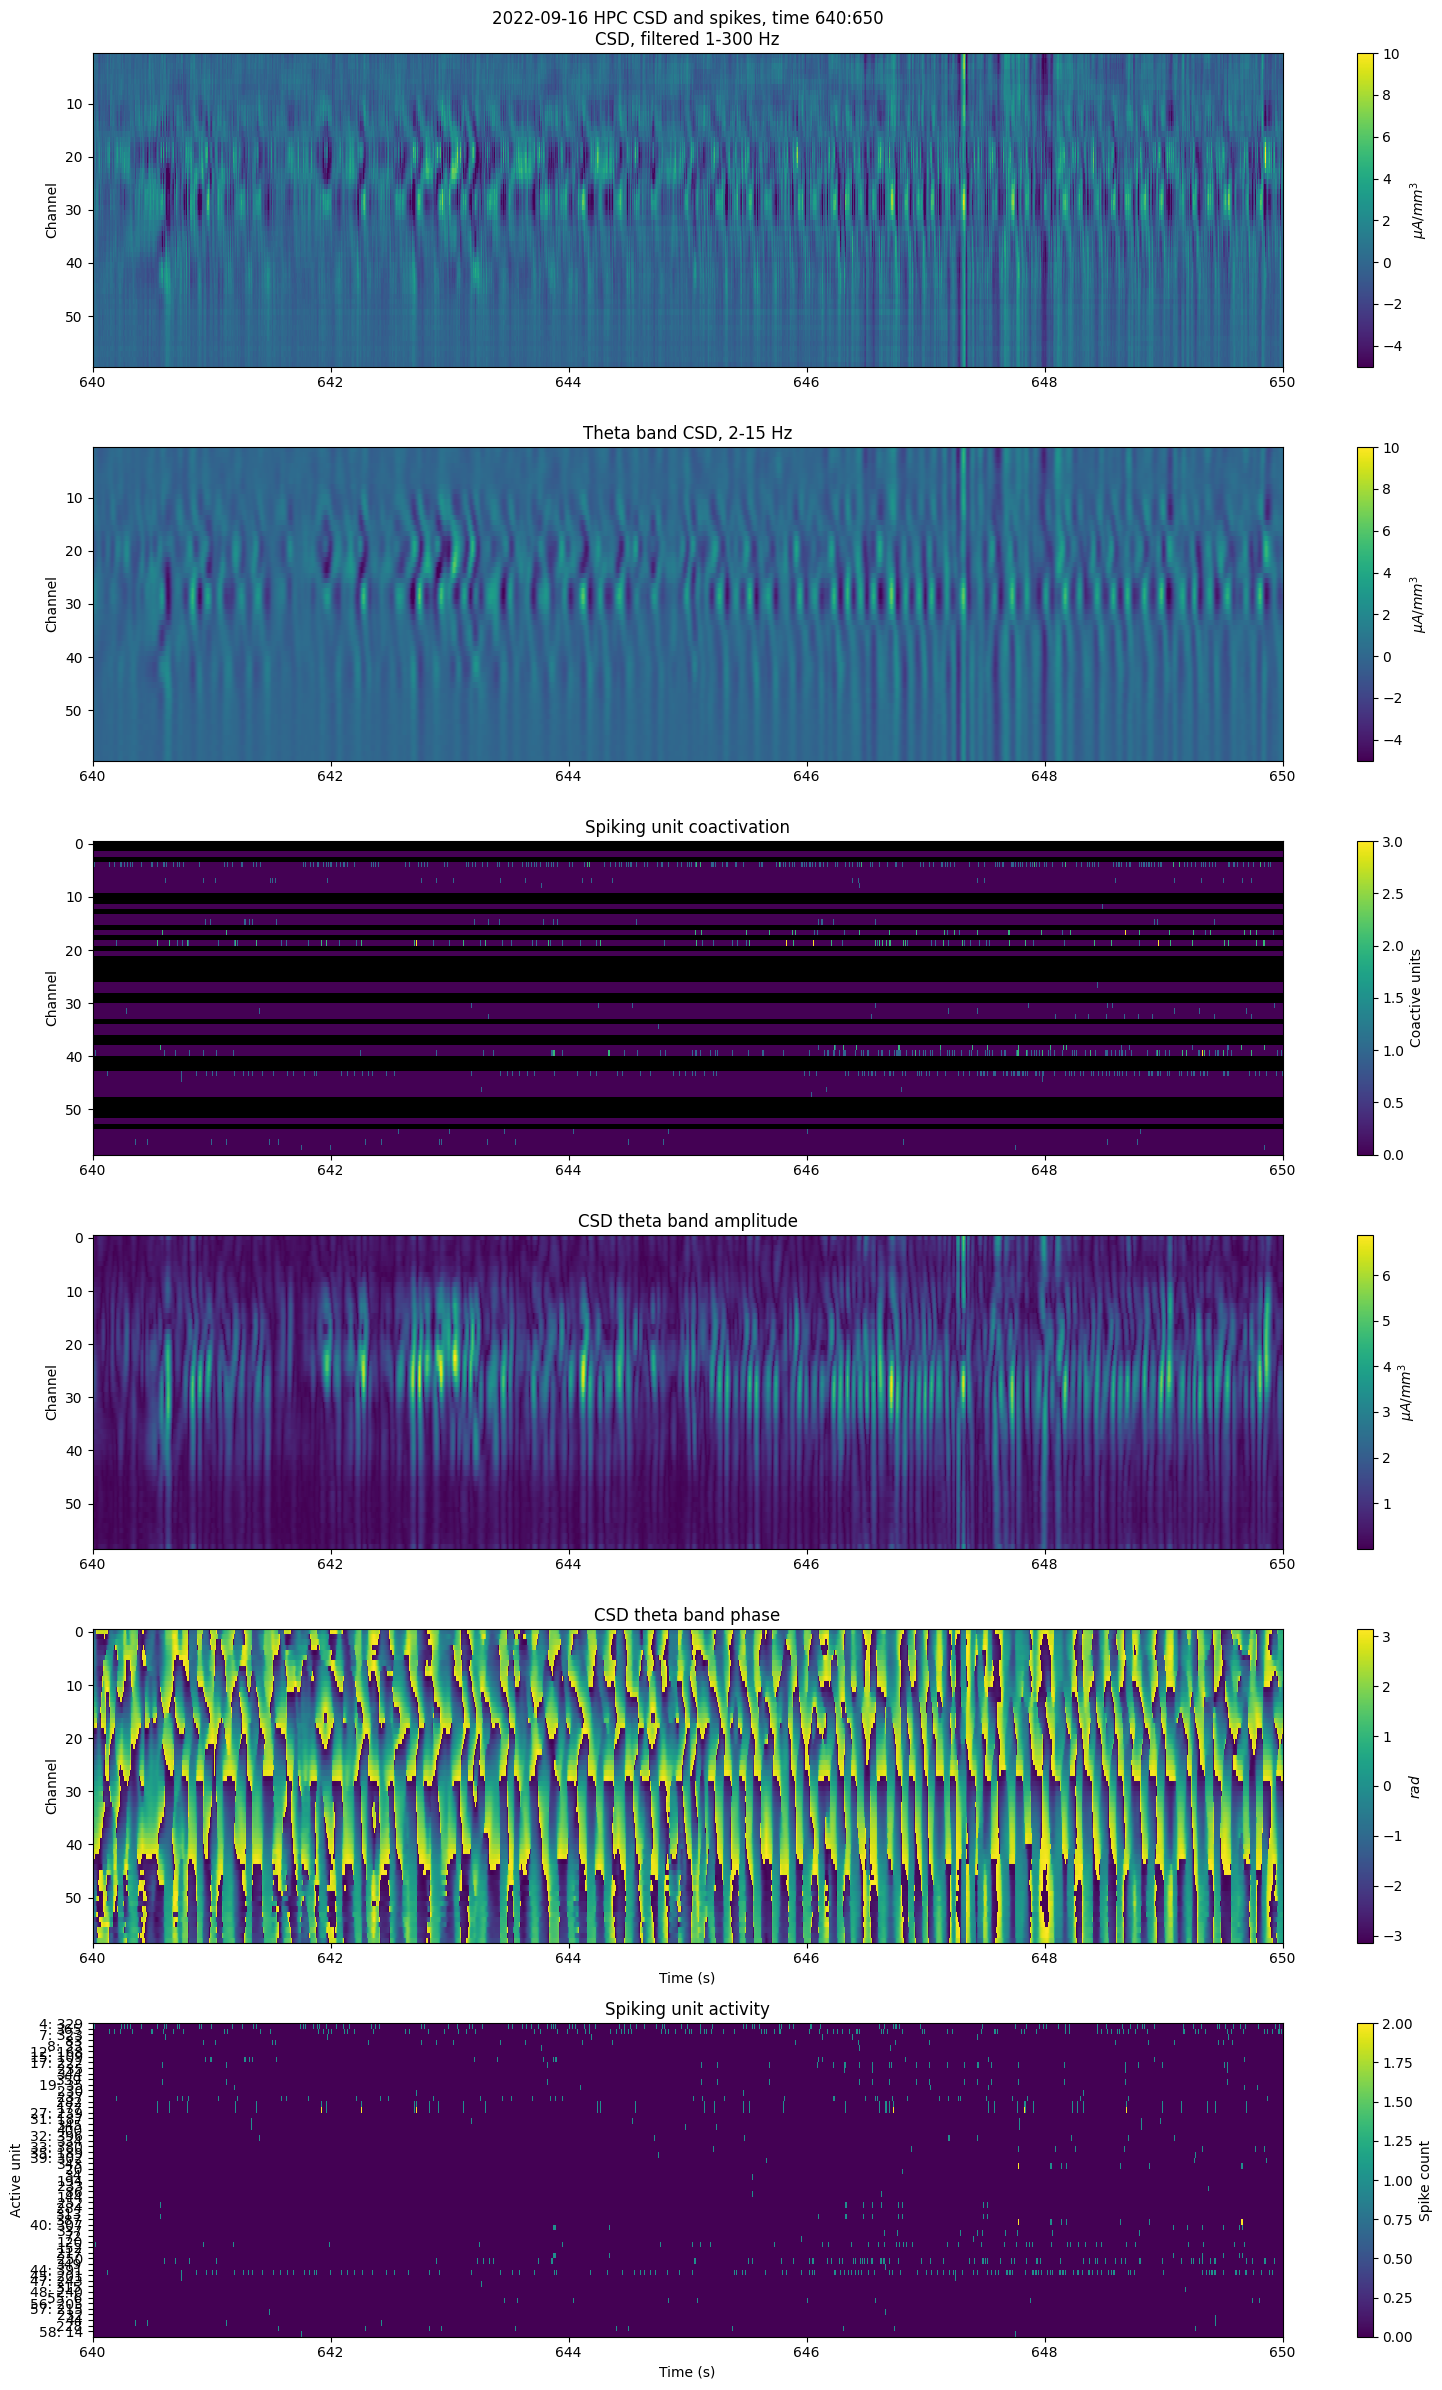

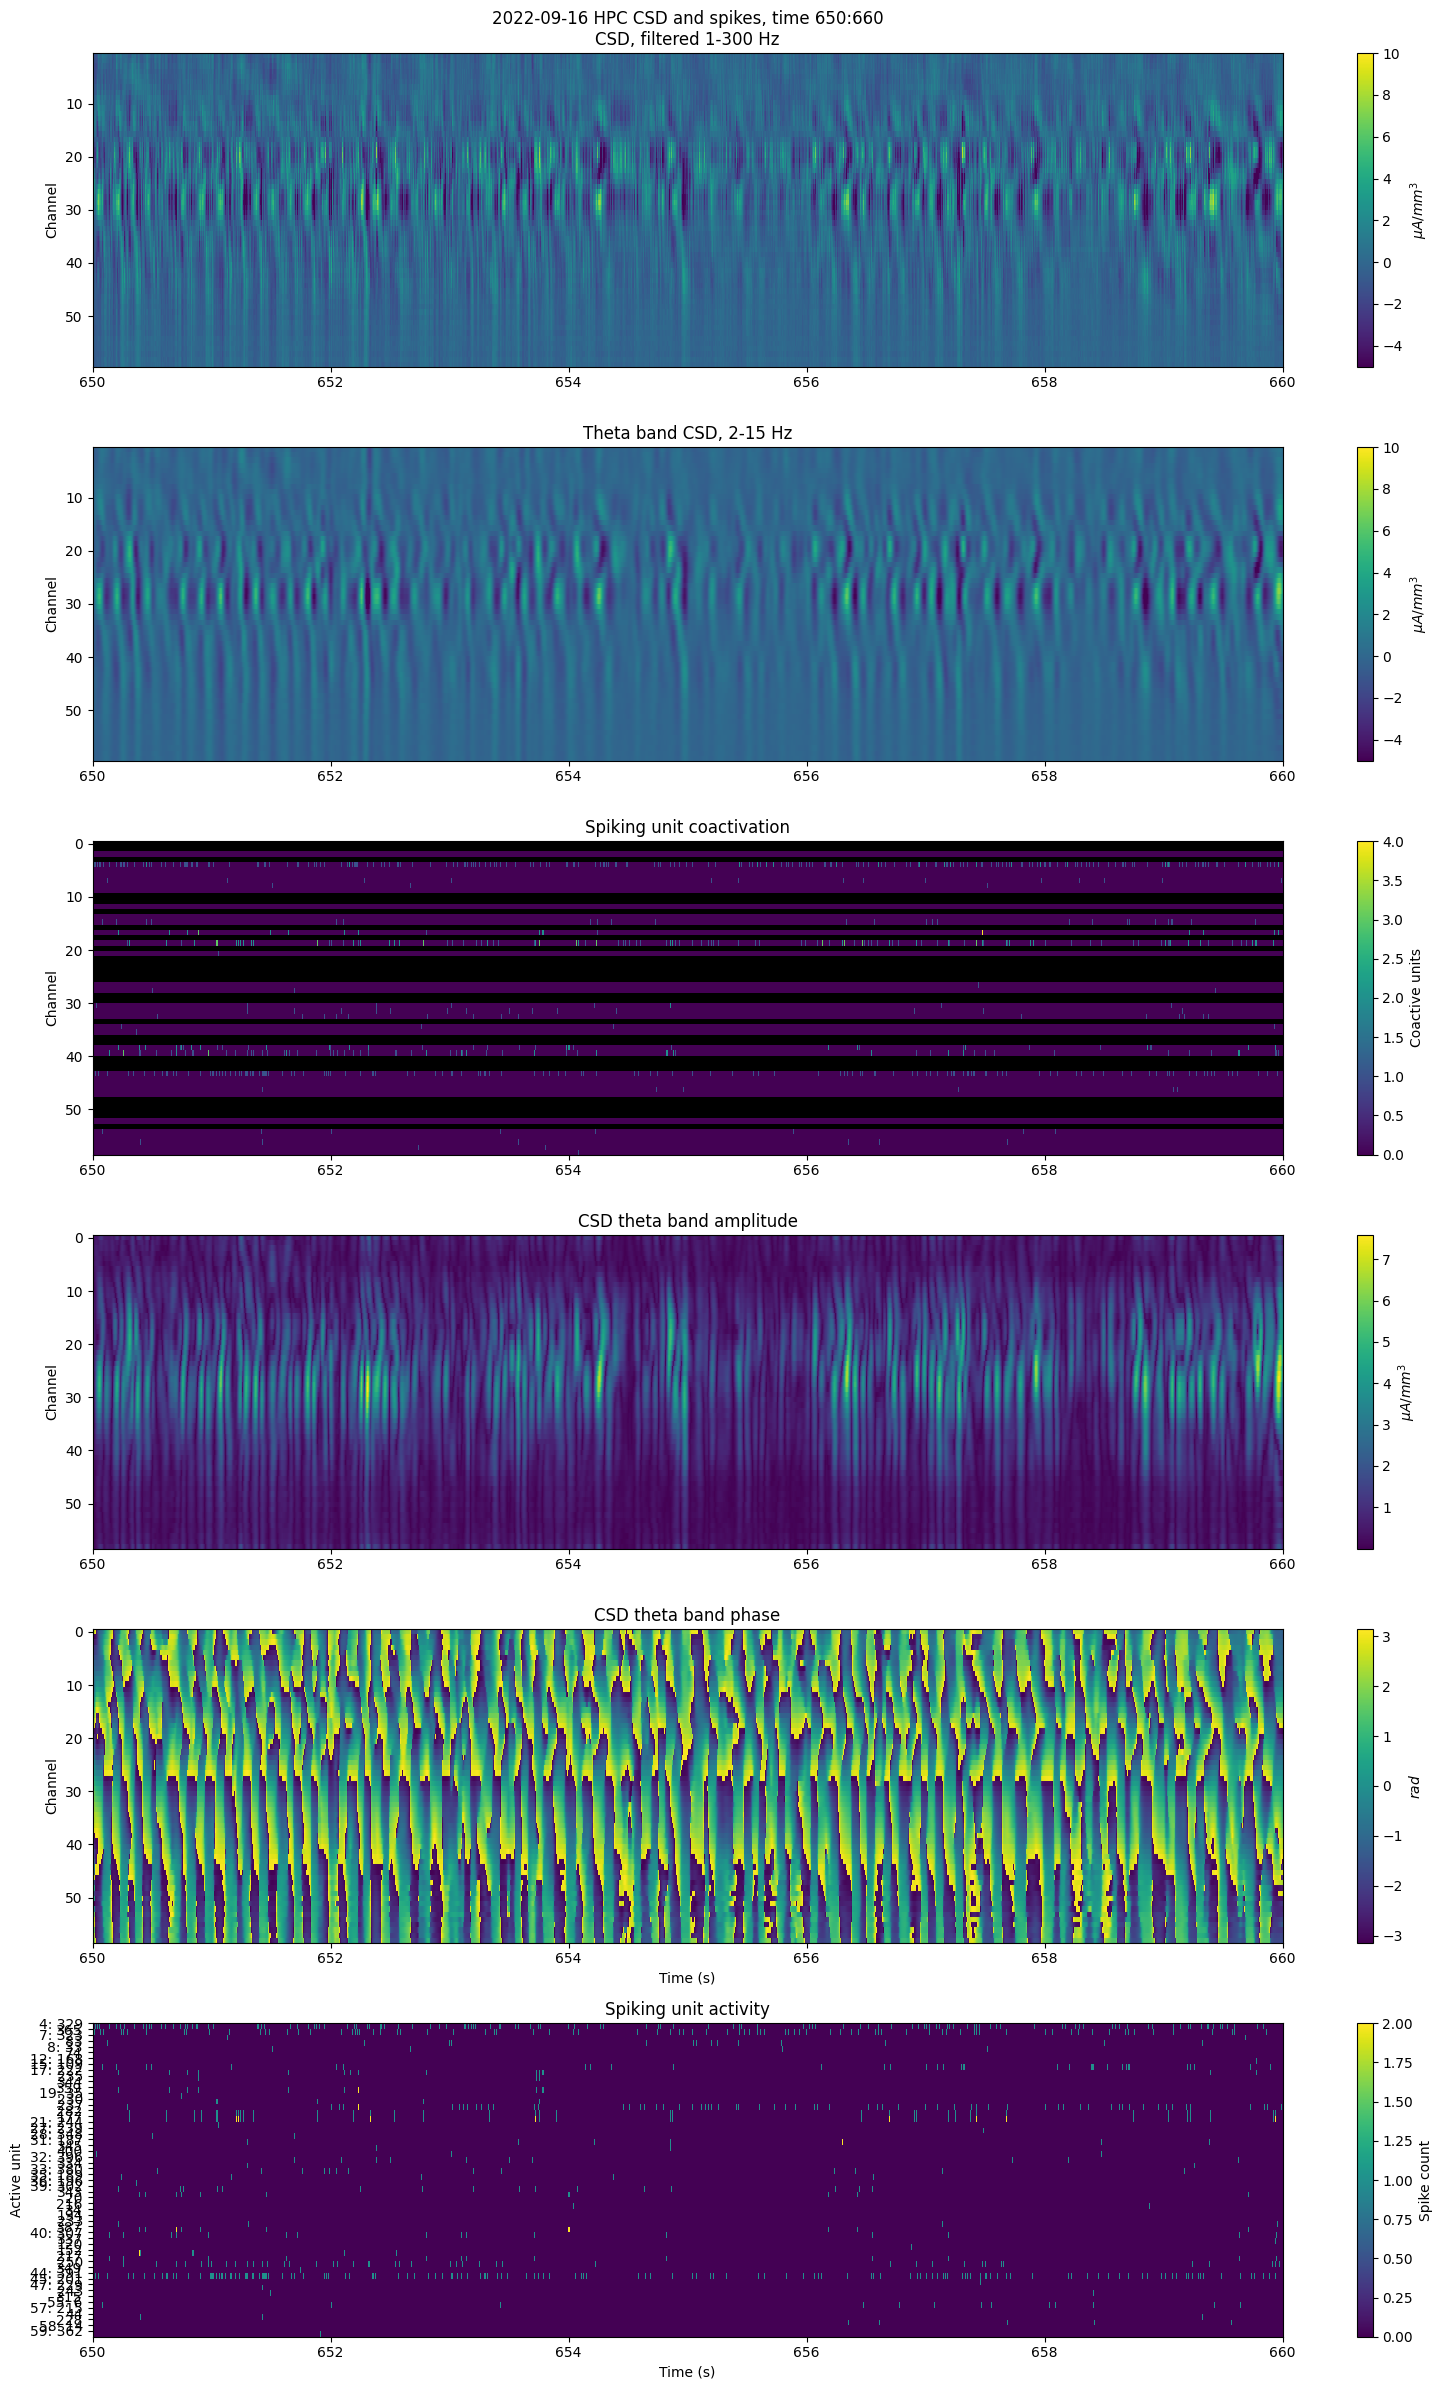

In [13]:
for start, end in zip(offset, offset + 10):
    fig, axs = plt.subplots(6, 1, figsize=(16, 24))
    title = f'{DATE} HPC CSD and spikes, time {start}:{end}'
    lim = [start, end, CHANNEL_MAX + 0.5, CHANNEL_MIN + 0.5]
    tau = 1 / 250

    plt.sca(axs[0])
    plt.imshow(csd.loc[start:end - tau].T, extent=lim, vmin=-5, vmax=10, interpolation='none')
    plt.title(f'{title}\nCSD, filtered 1-300 Hz')
    plt.ylabel('Channel')
    plt.axis('auto')
    plt.colorbar(label='$\mu A/{mm}^3$')

    plt.sca(axs[1])
    plt.imshow(theta.loc[start:end - tau].T, extent=lim, vmin=-5, vmax=10, interpolation='none')
    plt.title(f'Theta band CSD, 2-15 Hz')
    plt.ylabel('Channel')
    plt.axis('auto')
    plt.colorbar(label='$\mu A/{mm}^3$')

    plt.sca(axs[2])
    lim = [start, end, CHANNEL_MAX - 0.5, CHANNEL_MIN - 0.5]
    cmap = plt.get_cmap('viridis')
    cmap.set_bad('black')
    plt.imshow(coact.loc[start:end].T, extent=lim, cmap=cmap, interpolation='none')
    plt.title(f'Spiking unit coactivation')
    plt.ylabel('Channel')
    plt.axis('auto')
    plt.colorbar(label='Coactive units');

    plt.sca(axs[3])
    plt.imshow(np.abs(hilbert.loc[start:end - tau].T), extent=lim, interpolation='none')
    plt.title(f'CSD theta band amplitude')
    plt.ylabel('Channel')
    plt.axis('auto')
    plt.colorbar(label='$\mu A/{mm}^3$')

    plt.sca(axs[4])
    plt.imshow(np.angle(hilbert.loc[start:end - tau].T), extent=lim, interpolation='none')
    plt.title(f'CSD theta band phase')
    plt.ylabel('Channel')
    plt.xlabel('Time (s)')
    plt.axis('auto')
    plt.colorbar(label='$rad$')

    plt.sca(axs[5])
    spk = spikes.loc[start:end - tau]
    spk = spk.loc[:, spk.sum(axis=0) > 0]
    lim = [start, end, len(spk.columns), 0]
    plt.imshow(spk.T, extent=lim, interpolation='none')
    plt.title(f'Spiking unit activity')
    plt.axis('auto')
    plt.ylabel('Active unit')
    unit = spk.columns.to_frame()['unit']
    chan = spk.columns.to_frame()['channel'] // 4
    chan.iloc[np.where(chan.diff() == 0)[0]] = -1
    name = [(f'{chanid}: ' if chanid > -1 else '') + str(unitid) for chanid, unitid in zip(chan, unit)]
    plt.yticks(range(len(spk.columns)), name)
    plt.colorbar(label='Spike count')
    plt.xlabel('Time (s)')

    plt.tight_layout()
    plt.savefig(f'{DATE}-hpc-theta-spikes-time-{start}-{end}.png', dpi=300)
    plt.show()